<a href="https://colab.research.google.com/github/zbiswas3/Datascience-Projects/blob/master/Capstone%20Project%202%20-%20MS%20Coco%20Image%20Captioning/capstone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [0]:
%matplotlib inline
from __future__ import print_function
from pycocotools.coco import COCO
import os, sys, zipfile
import urllib.request
import shutil
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

## Load Data

In [0]:
# Setup data paths
dataDir = '../..'
dataType = 'val2017'
annDir = '{}/annotations'.format(dataDir)
annZipFile = '{}/annotations_train{}.zip'.format(dataDir, dataType)
annFile = '{}/instances_{}.json'.format(annDir, dataType)
annURL = 'http://images.cocodataset.org/annotations/annotations_train{}.zip'.format(dataType)


In [3]:
# Download data if not available locally
if not os.path.exists(annDir):
    os.makedirs(annDir)
if not os.path.exists(annFile):
    if not os.path.exists(annZipFile):
        print ("Downloading zipped annotations to " + annZipFile + " ...")
        with urllib.request.urlopen(annURL) as resp, open(annZipFile, 'wb') as out:
            shutil.copyfileobj(resp, out)
        print ("... done downloading.")
    print ("Unzipping " + annZipFile)
    with zipfile.ZipFile(annZipFile,"r") as zip_ref:
        zip_ref.extractall(dataDir)
    print ("... done unzipping")
print ("Will use annotations in " + annFile)

... done downloading.
Unzipping ../../annotations_trainval2017.zip
... done unzipping
Will use annotations in ../../annotations/instances_val2017.json


In [4]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.66s)
creating index...
index created!


In [5]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
indoor kitchen appliance outdoor vehicle animal accessory food electronic sports furniture person


## Data Samples

In [0]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person','dog','skateboard']);
imgIds = coco.getImgIds(catIds=catIds );
imgIds = coco.getImgIds(imgIds = [549220])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
A dog on a leash trying to ride a skateboard.
A small dog standing on top of a skateboard.
A very cute dog standing on a skate board.
a dog that is sitting on a skate board
a close up of a dog riding a skate board 


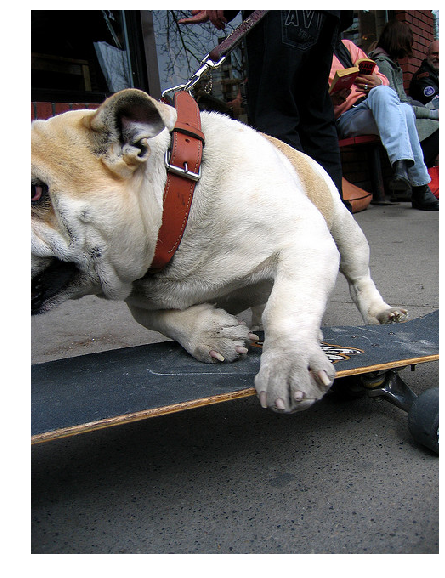

In [7]:
# load and display image
I = io.imread(img['coco_url'])
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)

# initialize COCO api for person keypoints annotations
annFile = '{}/annotations/person_keypoints_{}.json'.format(dataDir,dataType)
coco_kps=COCO(annFile)

# load and display keypoints annotations
annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco_kps.loadAnns(annIds)

# initialize COCO api for caption annotations
annFile = '{}/annotations/captions_{}.json'.format(dataDir,dataType)
coco_caps=COCO(annFile)

# load and display caption annotations
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.imshow(I); plt.axis('off'); plt.show()

In [8]:
print("Dataset Containsts {} images.".format(len(coco.imgs.keys())))
print("Training data has {} Categories.".format(len(coco.cats.keys())))

Dataset Containsts 5000 images.
Training data has 80 Categories.


## Form Dataframes from the Training Data

In [9]:
# all the images and corresponding sources
img_data = pd.DataFrame(coco.dataset['images']).rename(index=str, columns={'id':'image_id'})
captions = pd.DataFrame(coco_caps.dataset['annotations']).rename(index=str, columns={'id':'caption_id'})
print("{} total images are available.".format(len(set(img_data.image_id))))
print("{} images have captions available.".format(len(set(captions.image_id))))


5000 total images are available.
5000 images have captions available.


In [10]:
train_data = pd.merge(img_data, captions, how='inner', on = ['image_id'] )
train_df = train_data.drop_duplicates(subset='image_id')
train_df.caption = 'startings '+ train_df.caption.str.lower() + ' endings'
train_df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,coco_url,date_captured,file_name,flickr_url,height,image_id,license,width,caption,caption_id
0,http://images.cocodataset.org/val2017/00000039...,2013-11-14 17:02:52,000000397133.jpg,http://farm7.staticflickr.com/6116/6255196340_...,427,397133,4,640,startings a man is in a kitchen making pizzas....,370509
5,http://images.cocodataset.org/val2017/00000003...,2013-11-14 20:55:31,000000037777.jpg,http://farm9.staticflickr.com/8429/7839199426_...,230,37777,1,352,startings the dining table near the kitchen ha...,597185
10,http://images.cocodataset.org/val2017/00000025...,2013-11-14 22:32:02,000000252219.jpg,http://farm4.staticflickr.com/3446/3232237447_...,428,252219,4,640,startings a person with a shopping cart on a c...,107395
15,http://images.cocodataset.org/val2017/00000008...,2013-11-14 23:11:37,000000087038.jpg,http://farm8.staticflickr.com/7355/8825114508_...,480,87038,1,640,startings a person on a skateboard and bike at...,647151
20,http://images.cocodataset.org/val2017/00000017...,2013-11-14 23:16:55,000000174482.jpg,http://farm8.staticflickr.com/7020/6478877255_...,388,174482,6,640,startings a blue bike parked on a side walk e...,429740


## Build an Image Encoder (VGG16)

In [11]:
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential, load_model, Model
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.applications import VGG16, ResNet50
from keras.preprocessing import image, text
from PIL import Image
# image_model = VGG16(weights='imagenet', include_top=True)
image_model = ResNet50(weights='imagenet', include_top=True)

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


102858752/102853048 [==============================] - 4s 0us/step


In [0]:
image_size = (224, 224)

In [13]:
# for vgg16 model
# transfer_layer = image_model.get_layer('fc1')
# image_model_transfer = Model(inputs=image_model.input, outputs=transfer_layer.output)

# for resnet50 model 
image_model_transfer = Model(inputs=image_model.input, outputs=image_model.output)

image_model_transfer.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
# define a processor for all the training and test images
def image_preprocessor(url, image_size, file_name):
  urllib.request.urlretrieve(url, file_name)
  sample_img = image.load_img(file_name, target_size=image_size)
  sample_img_arr = image.img_to_array(sample_img)
  sample_img_arr = sample_img_arr.reshape((1, sample_img_arr.shape[0], sample_img_arr.shape[1], sample_img_arr.shape[2]))
  input_img = preprocess_input(sample_img_arr)
  return image_model_transfer.predict(input_img)

In [15]:
%%time
transfer_values = []
for i in range(train_df.shape[0]):
  transfer_values.append(image_preprocessor(train_df.coco_url.iloc[i], image_size, train_df.file_name.iloc[i]))

CPU times: user 3min 9s, sys: 1min 22s, total: 4min 31s
Wall time: 44min 37s


## Process Caption Data




In [16]:
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
num_words = 6000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_df.caption.values)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(train_df.caption.values)
print(dtexts[:5])

vocabulary size : 3428
[[2, 1, 12, 11, 7, 1, 70, 430, 643, 3], [2, 6, 346, 26, 38, 6, 70, 63, 1, 144, 4, 210, 5, 34, 3], [2, 1, 30, 8, 1, 788, 411, 5, 1, 76, 24, 3], [2, 1, 30, 5, 1, 90, 9, 238, 20, 1, 362, 145, 3], [2, 1, 61, 238, 68, 5, 1, 43, 374, 3]]


In [0]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])

In [18]:
maxlen = np.max([len(text) for text in dtexts])
print('Size of the longest caption:',maxlen)

Size of the longest caption: 30


## Split Train , Test, and Validation Data

In [0]:
prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(transfer_values,Ntest,Nval)

In [20]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages)) # using assert to make sure that length of images and captions are always similar
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):
        # zip() is used to create a tuple of iteratable items
        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()# using pad sequence to make the length of all captions equal
            out_text = to_categorical(out_text,num_classes = vocab_size) # using to_categorical to 
            
            Xtext.append(in_text)
            Ximage.append(image.flatten())
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage, )
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)


# captions/images = 3000
 (34221, 30) (34221, 1000) (34221, 3428)
# captions/images = 1000
 (11294, 30) (11294, 1000) (11294, 3428)


### Building LSTM Model

In [0]:
from keras.layers import Input, LSTM, Dropout, TimeDistributed, Dense, Flatten, Dropout, Activation, Embedding

In [22]:
from keras import layers


## image feature
dim_embedding = 128  

input_image = Input(shape=(transfer_values[0].shape[1],))
fe1 = Dropout(0.3)(input_image)
fimage = Dense(128, activation='relu',name="ImageFeature")(fe1)

## sequence model
input_txt = Input(shape=(maxlen,))
embedding = Embedding(vocab_size, dim_embedding, mask_zero=True)(input_txt)
# ftxt1 = LSTM(256, name="CaptionFeature_1", return_sequences=True, activation='tanh')(embedding)
se1 = Dropout(0.5)(embedding)
ftxt = LSTM(128, activation='tanh' ,name="CaptionFeature_2")(se1)

## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = Dense(128, activation='relu')(decoder)
output = Dense(vocab_size, activation='softmax')(decoder)
cap_model = Model(inputs=[input_image, input_txt], outputs=output)

cap_model.compile(loss='categorical_crossentropy', optimizer='adam') # try adam 

print(cap_model.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 128)      438784      input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 30, 128)      0           embedding_1[0][0]           

In [23]:
#Train The model
%%time
from keras.callbacks import TensorBoard
from time import time
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
hist = cap_model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=5, verbose=2, 
                  batch_size=32,
                  validation_data=([Ximage_val, Xtext_val], ytext_val),callbacks=[tensorboard])

Instructions for updating:
Use tf.cast instead.
Train on 34221 samples, validate on 11294 samples
Epoch 1/5
 - 105s - loss: 5.0153 - val_loss: 4.5124
Epoch 2/5
 - 105s - loss: 4.1559 - val_loss: 4.3077
Epoch 3/5
 - 105s - loss: 3.8512 - val_loss: 4.2054
Epoch 4/5
 - 105s - loss: 3.6254 - val_loss: 4.1647
Epoch 5/5
 - 105s - loss: 3.4440 - val_loss: 4.1098
CPU times: user 12min 26s, sys: 1min 31s, total: 13min 58s
Wall time: 8min 50s


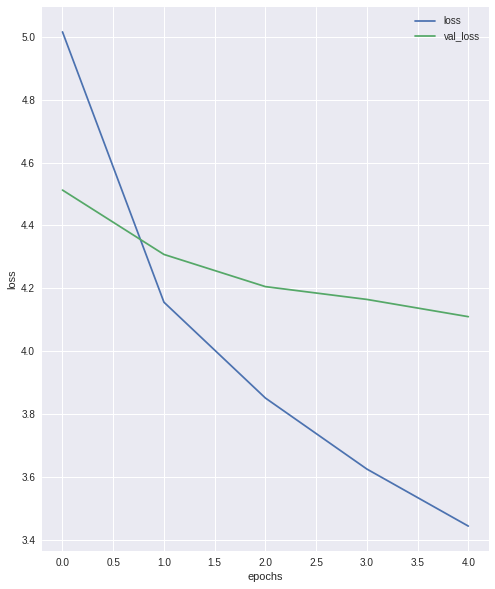

In [24]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [0]:
#fnames are the names of the image files        
fnames = train_df.file_name.values
#dcaptions are the captions of the images 
dcaptions = train_df.caption.values

In [0]:
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [0]:
from keras.preprocessing.image import load_img, img_to_array

def predict_caption(image):
    '''
    image.shape = (1,4096)
    '''

    in_text = ''

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = cap_model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]        
        if newword == "endings":
            break
        in_text += " " + newword

    return(in_text)



## Evaluating The Model Performance

In [0]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smoothie = SmoothingFunction().method4

def model_evaluator(fnm, di, dt, nkeep = 5):
  pred_good, pred_bad, bleus = [], [], [] 
  count = 0 
  for jpgfnm, image_feature, tokenized_text in zip(fnm, di, dt):
      count += 1
      caption_true = [ index_word[i] for i in tokenized_text ]     
      caption_true = caption_true[1:-1] ## remove starting, and ending
      
      ## captions
      caption = predict_caption(image_feature)
      caption = caption.split()
      caption = caption[1:-1]## remove starting, and ending
      bleu = sentence_bleu([caption_true],caption, smoothing_function=smoothie)
      bleus.append(bleu)
      if bleu > 0.7 and len(pred_good) < nkeep:
          pred_good.append((bleu,jpgfnm,caption_true,caption))
      elif bleu < 0.3 and len(pred_bad) < nkeep:
          pred_bad.append((bleu,jpgfnm,caption_true,caption))
  print("Mean BLEU {:4.3f}".format(np.mean(bleus)))
  

In [29]:
print('For Test Data: ')
model_evaluator(fnm_test, di_test, dt_test)

print('For Training Data: ')
model_evaluator(fnm_train, di_train, dt_train)

For Test Data: 
Mean BLEU 0.124
For Training Data: 
Mean BLEU 0.127


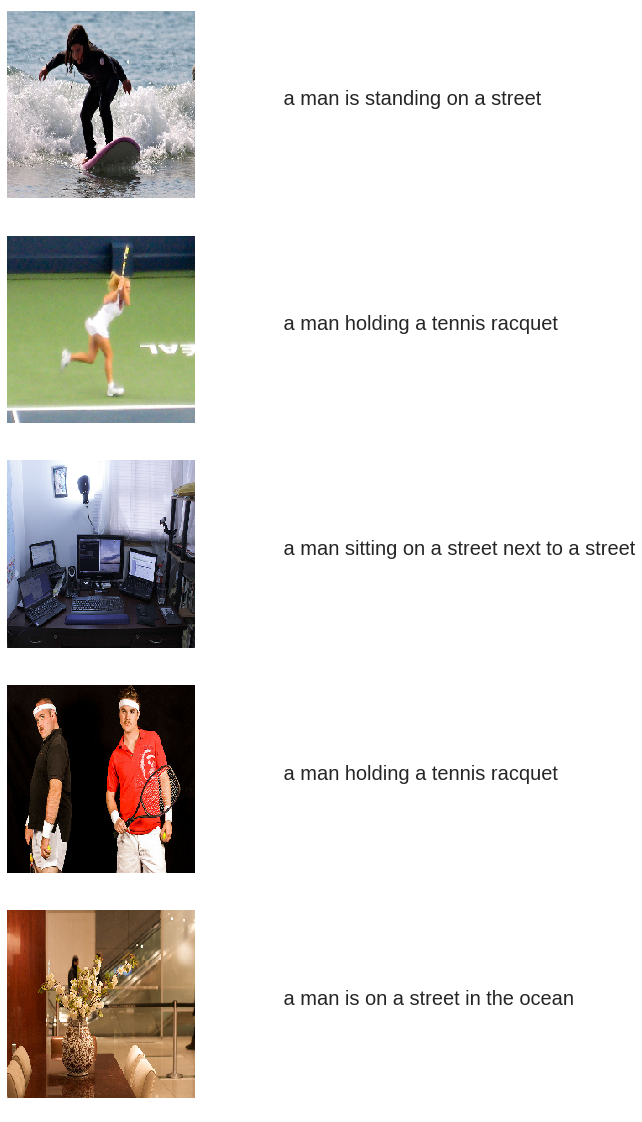

In [30]:
# show a few sample of the prediction
npic = 5
target_size = (224, 224, 3)

count = 1
fig = plt.figure(figsize=(10, 20))
for jpgfnm, image_feature in zip(fnm_train[8:13],di_train[8:13]):
    ## images 
    filename = jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature)
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()